In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/root/anaconda3/envs/lib/R'

In [3]:
import anndata as ad


adata = sc.read('/data/1122/SpatialHSM/Data/STARmap/STARmap.h5ad')

print(adata)

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Cell', 'Cell_type', 'X', 'Y', 'Layer'
    obsm: 'spatial'


In [4]:
import numpy as np


In [5]:
import os
os.chdir('/data/1122/SpatialHSM')

In [6]:
import SpatialHSM
from SpatialHSM import SpatialHSM

Extracting feature ...
Feature extracted!
Integrating frequency features...


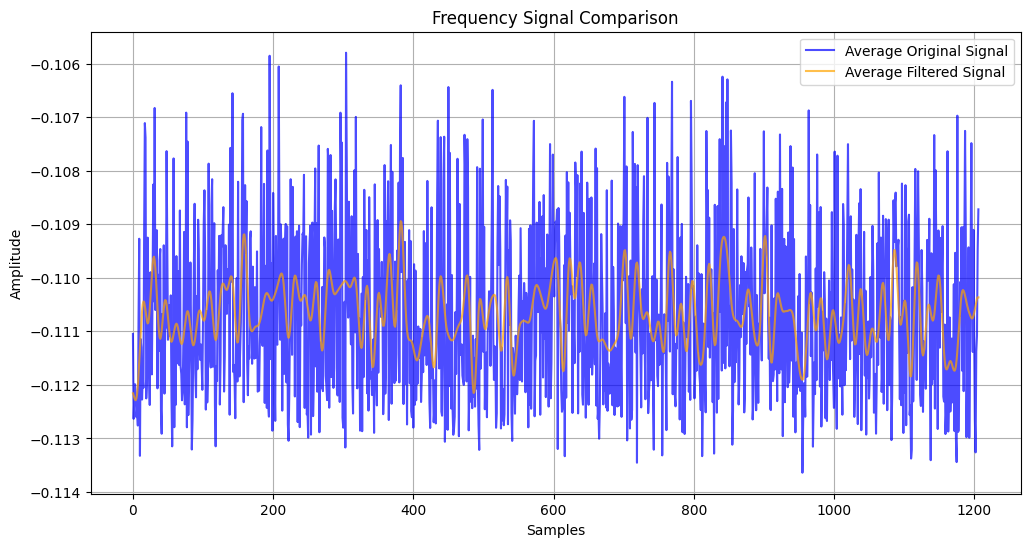

Performing PCA to reduce dimensions...
Features after PCA reduction: torch.Size([1207, 1020])
Frequency feature integration completed in 1.30 seconds
Memory used: 37.21 MB
GPU memory: 0.00 MB allocated, 0.00 MB reserved


In [7]:
# define model
model = SpatialHSM(adata, device=device,epochs=1000)#2024
#epochs=3000,random_seed=2800

EncoderAttentionResidualMLP
HSMSSDEnhancedAttentionLayer
Begin to train ST data ...


Training Progress: 100%|██████████| 1000/1000 [01:14<00:00, 13.46it/s]


Optimization finished for ST data!


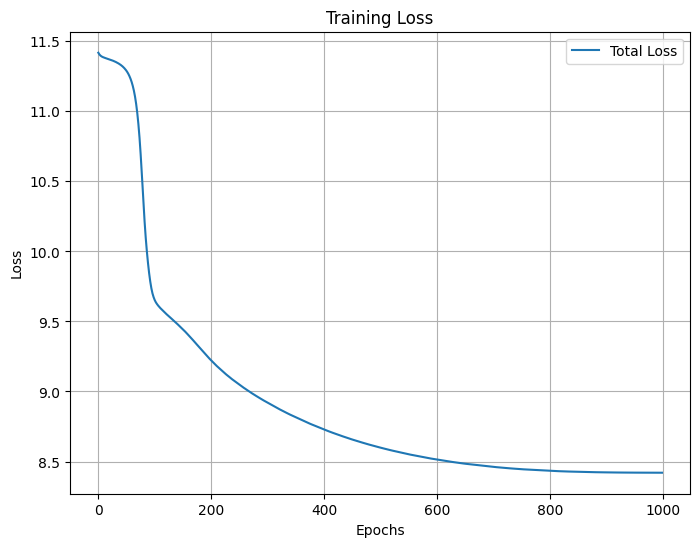


====== TRAINING PERFORMANCE SUMMARY ======
Total training time: 74.87 seconds
Memory used: 1017.34 MB
GPU memory: 0.00 MB allocated, 0.00 MB reserved



In [8]:
# train model
adata = model.train()

In [9]:
adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Cell', 'Cell_type', 'X', 'Y', 'Layer'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


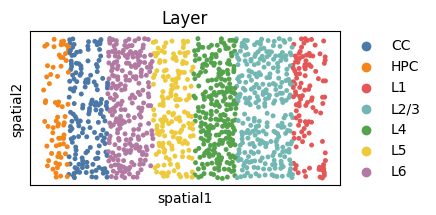

In [10]:
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

# Set figure size
plt.rcParams["figure.figsize"] = (4, 2)

# Define layer colors - sophisticated and easily distinguishable palette
layer_colors = {
    'CC': '#4C78A8',         # Steel blue
    'HPC': '#F58518',        # Orange
    'L1': '#E45756',         # Coral red
    'L2/3': '#72B7B2',       # Teal
    'L4': '#54A24B',         # Forest green
    'L5': '#EECA3B',         # Gold
    'L6': '#B279A2'          # Purple
}

# Plot only layers with custom colors
sc.pl.embedding(
    adata, 
    basis="spatial", 
    color='Layer',
    palette=layer_colors,
    s=50,
    show=True,
    title='Layer'
)

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


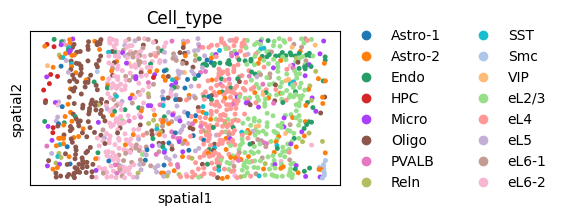

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 2)
sc.pl.embedding(adata, basis="spatial", color=['Cell_type'],s=50, )

In [12]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

n_clusters=7
tool = 'mclust' # mclust, leiden, and louvain

# clustering
from SpatialHSM.utils import clustering,mclust_R

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [13]:
adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Cell', 'Cell_type', 'X', 'Y', 'Layer', 'mclust', 'domain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'Layer_colors', 'Cell_type_colors'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb', 'emb_pca'

In [25]:
import anndata as ad


file_path = "/data/1122/SpatialHSM/Data/STARmap/save_STARmap_seed_4961_ari_0.6511_best.h5ad"
adata = ad.read_h5ad(file_path)


print(adata)

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Cell', 'Cell_type', 'X', 'Y', 'Layer', 'ground_truth', 'mclust', 'domain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'domain_colors', 'hvg', 'log1p'
    obsm: 'adj', 'distance_matrix', 'emb', 'emb_pca', 'feat', 'feat_a', 'graph_neigh', 'label_CSL', 'spatial'


In [26]:
adata.obs['ground_truth']=adata.obs['Layer']
adata.obs['ground_truth']

Cell_9         L6
Cell_10        L4
Cell_13      L2/3
Cell_15        L6
Cell_16        L4
             ... 
Cell_1382      L6
Cell_1383      L6
Cell_1385    L2/3
Cell_1387      L1
Cell_1389      L4
Name: ground_truth, Length: 1207, dtype: category
Categories (7, object): ['CC', 'HPC', 'L1', 'L2/3', 'L4', 'L5', 'L6']

In [27]:
SpatialHSM_single_meta = pd.read_csv('/data/1122/SpatialHSM/Data/STARmap/STARmap_seed_4961_ari_0.6511.csv',index_col=0)

adata.obs['SpatialHSM'] = pd.Categorical(SpatialHSM_single_meta.iloc[:,-1])


In [28]:
import pandas as pd
from sklearn import metrics
from sklearn.metrics import (
    homogeneity_score, mutual_info_score, v_measure_score,
    adjusted_mutual_info_score, normalized_mutual_info_score,
    adjusted_rand_score
)


# adata = adata[~pd.isnull(adata.obs['ground_truth'])]


ARI = metrics.adjusted_rand_score(adata.obs['Layer'], adata.obs['domain'])
adata.uns['SpatialHSMARI'] = ARI


homogeneity = homogeneity_score(adata.obs['Layer'], adata.obs['domain'])
mutual_info = mutual_info_score(adata.obs['Layer'], adata.obs['domain'])
v_measure = v_measure_score(adata.obs['Layer'], adata.obs['domain'])
ami = adjusted_mutual_info_score(adata.obs['Layer'], adata.obs['domain'])
nmi = normalized_mutual_info_score(adata.obs['Layer'], adata.obs['domain'])


adata.uns['SpatialHSM_homogeneity'] = homogeneity
adata.uns['SpatialHSM_mutual_info'] = mutual_info
adata.uns['SpatialHSM_v_measure'] = v_measure
adata.uns['SpatialHSM_AMI'] = ami
adata.uns['SpatialHSM_NMI'] = nmi


print('ARI:', ARI)
print('Homogeneity:', homogeneity)
print('Mutual Info:', mutual_info)
print('V-measure:', v_measure)
print('AMI:', ami)
print('NMI:', nmi)

ARI: 0.6511332063586548
Homogeneity: 0.6920289061817421
Mutual Info: 1.2946244247977992
V-measure: 0.7185092397882213
AMI: 0.7160889955752973
NMI: 0.7185092397882212


In [29]:
adata

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Cell', 'Cell_type', 'X', 'Y', 'Layer', 'ground_truth', 'mclust', 'domain', 'SpatialHSM'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'domain_colors', 'hvg', 'log1p', 'SpatialHSMARI', 'SpatialHSM_homogeneity', 'SpatialHSM_mutual_info', 'SpatialHSM_v_measure', 'SpatialHSM_AMI', 'SpatialHSM_NMI'
    obsm: 'adj', 'distance_matrix', 'emb', 'emb_pca', 'feat', 'feat_a', 'graph_neigh', 'label_CSL', 'spatial'

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


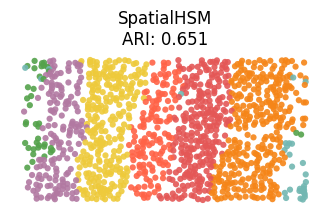

In [33]:
custom_palette = {
    '0': '#4C78A8',         
    '1': '#F58518',       
    '2': '#E45756',         
    '3': '#72B7B2',         
    '4': '#54A24B',         
    '5': '#EECA3B',        
    '6': '#B279A2',       
    '7': '#FF6347'          
}


title_text = f"{sample_name}\nARI: {ari_value}" if ari_value == 'N/A' else f"{sample_name}\nARI: {ari_value:.3f}"

sc.pl.embedding(
    adata,
    basis="spatial",
    color='SpatialHSM',
    s=80,                 
    show=True,
    title=title_text,
    palette=custom_palette,
    frameon=False,          
    legend_loc=None,        
    alpha=0.9               
)
